## Sequence to sequence model for making second part of ferdosi poems
              Adel Parvizi

importing needed libreries

In [2]:
import torch.optim as optim
import torch
import time
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
import random
import math
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
!pip install nltk
import nltk
nltk.download('punkt')
from collections import Counter
import os
import os.path
import pickle
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


check avilable devices

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
print("PyTorch Version : {}".format(torch.__version__))
print("TorchText Version : {}".format(torchtext.__version__))

PyTorch Version : 2.0.1+cu118
TorchText Version : 0.15.2+cpu


I've borrow this class from a site. Acually this class get a list of strings and give us a model that have two dictionary which associate words with indexes and vic versa.
* If we have a vocabulary we'll use that if not we need to build ones.
* At first we add "sos", "eos", "unk" to vocab. thay are nessesiry to be there. After that we tokenize sentences and add the tokens to vocab.
* I've delet numbers and unwanted tokens.

* add_captions: works on sentenses and after converting them to token, it will add them to vocab using "add_word"
* add_word: adds tokens to vab.

* __call__ get a list/single string and convert them/that to index

In [5]:
class Vocabulary(object):

    def __init__(self, vocab_threshold, vocab_file='/content/drive/MyDrive/Colab_Notebooks/Seqence_to_Sequence/vocab.pkl',
        start_word="<sos>", end_word="<eos>", unk_word="<unk>",
        poem_list='/content/annotations/captions_train2014.json', vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.poem_list = poem_list
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):

        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        counter = Counter()
        for i, poem in enumerate(self.poem_list):
            # Remove punctuation by using regex
            rp_poem = re.sub(r'[^\w\s]','', poem)
            #remove numbers
            rnp_poem = re.sub(r'\d+', '', rp_poem)
            tokens = nltk.tokenize.word_tokenize(rnp_poem.lower())
            counter.update(tokens)

            if i % 20000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(self.poem_list)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
      if type(word) == str:
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]
      if type(word) == list:
        a = []
        for w in word:
          if not w in self.word2idx : a.append(self.word2idx[self.unk_word])
          else : a.append(self.word2idx[w])
        return a
    def __len__(self):
        return len(self.word2idx)

i split poes to first part and second parts and buils the vocab

In [6]:
with open('/content/drive/MyDrive/Colab_Notebooks/Seqence_to_Sequence/ferdousi.txt') as f:
  ferdousi_text = [line.strip() for line in f.readlines()]
ferdousi_text = ferdousi_text[2:]
print(f"num of beyt", len(ferdousi_text))
input_poems = [ferdousi_text[i] for i in range(len(ferdousi_text)) if i % 2 == 0]
output_poems = [ferdousi_text[i] for i in range(len(ferdousi_text)) if i % 2 == 1]
input_poems, output_poems = input_poems[0:49608], output_poems[0:49608]

vocabulary = Vocabulary(
    vocab_threshold=0,
    vocab_file='/content/drive/MyDrive/Colab_Notebooks/Seqence_to_Sequence/vocab.pkl',
    poem_list = input_poems + output_poems)

num of beyt 99217
[0/99216] Tokenizing captions...
[20000/99216] Tokenizing captions...
[40000/99216] Tokenizing captions...
[60000/99216] Tokenizing captions...
[80000/99216] Tokenizing captions...


# Testing our vocab

In [7]:
a = "به نام خداوند جان و خرد کزین برتر اندیشه برنگذرد"
tokens = nltk.tokenize.word_tokenize(str(a).lower())
b = [vocabulary(token) for token in tokens]
print(a)
print(b)
print("len of vocabulary: ", len(vocabulary))
print(vocabulary.idx2word[0])
print(vocabulary.idx2word[1])
print(vocabulary.idx2word[2])
print(vocabulary.idx2word[3])
print(vocabulary.idx2word[4])

به نام خداوند جان و خرد کزین برتر اندیشه برنگذرد
[3, 4, 5, 6, 7, 8, 394, 60, 23, 7229]
len of vocabulary:  17778
<sos>
<eos>
<unk>
به
نام


In [8]:
vocabulary("برنگذرد")

7229

# Spliting data to train, test and val

In [9]:
X, X_test, y, y_test = train_test_split(input_poems, output_poems, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
train_data = [[X_train[i], y_train[i]] for i in range(len(X_train))]
test_data = [[X_test[i], y_test[i]] for i in range(len(X_test))]
val_data = [[X_val[i], y_val[i]] for i in range(len(X_val))]
del input_poems, output_poems, X, X_test, y, y_test, X_train, X_val, y_train, y_val

In [10]:
print("train length", len(train_data),"\ntest length", len(test_data), "\nval length", len(val_data))

train length 29764 
test length 9922 
val length 9922


# Probing lengt of sentence(mesra')

In [11]:
a = [1,2,3]
a.reverse()
a

[3, 2, 1]

In [12]:
s =[]
for i in ferdousi_text:
  s.append(len(nltk.tokenize.word_tokenize(str(i).lower())))
res = np.std(s)
mn = np.mean(s)
print(mn, res)

5.730721549734421 1.0898380315180556


# Constructing Dataloader.
vectorize_batch coverts sentenses to token, add start and ending token to sentenses. Also it reverses sequense of tokens. Because it make network to have a beter training process

* I'm not sure that all the X and Y should be reversed or not

In [13]:
def vectorize_batch(batch):
    length = 9
    X, Y = list(zip(*batch))
    X = [vocabulary(nltk.tokenize.word_tokenize(sample)) for sample in X]
    [x.reverse() for x in X]
    X = [sample + ([2] * (length - len(sample))) if len(sample) < length else sample[:length] for sample in X]
    Y = [vocabulary(nltk.tokenize.word_tokenize(sample)) for sample in Y]
    [y.reverse() for y in Y]
    Y = [sample+([2]* (length-len(sample))) if len(sample)<length else sample[:length] for sample in Y]
    [x.append(1) for x in X]
    [y.append(1) for y in Y]
    [x.insert(0, 0) for x in X]
    [y.insert(0, 0) for y in Y]
    return torch.tensor(X, dtype=torch.int32).transpose(0, 1).to(device), torch.tensor(Y, dtype=torch.int32).transpose(0, 1).to(device)
train_data, test_data, val_data = to_map_style_dataset(train_data), to_map_style_dataset(test_data), to_map_style_dataset(val_data)
train_loader = DataLoader(train_data, batch_size=512, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_data, batch_size=1, collate_fn=vectorize_batch)
val_loader  = DataLoader(val_data, batch_size=512, collate_fn=vectorize_batch)

cheking that we have done well

In [14]:
len(train_loader)

59

In [42]:
data = iter(train_loader)

In [43]:
first_batch = next(data)

In [44]:
# batch_size : 512
print(first_batch[0].shape)
print(first_batch[1].shape)

torch.Size([11, 512])
torch.Size([11, 512])


In [45]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([11, 512]) torch.Size([11, 512])


In [46]:
first_batch[0][:,0].shape

torch.Size([11])

In [47]:
vocabulary.idx2word[4]

'نام'

In [21]:
second_batch = next(iter(train_loader))

In [22]:
s = []
for i in second_batch[0][:,1]:
  print(int(i))
  s.append(vocabulary.idx2word[int(i)])
print(s)

0
10182
199
58
509
83
21
2
2
2
1
['<sos>', 'کارمنست', 'نه', 'این', 'شاه', 'گفت', 'بدو', '<unk>', '<unk>', '<unk>', '<eos>']


Encoder is used to covert our embedding data to a space that we dont know what is it

* emb_dim: embedding dimention

* hid_dim: hidden dimension

* n_layers: number of layer

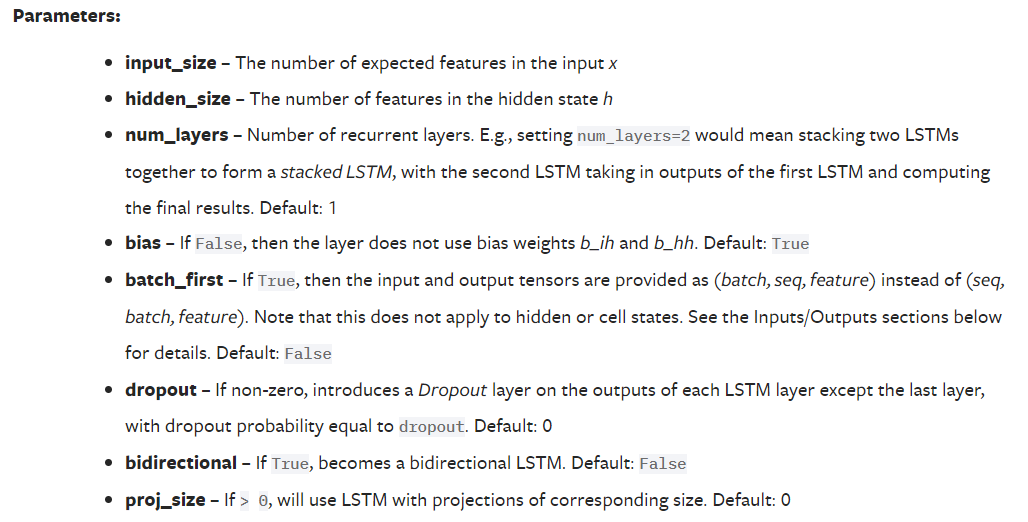

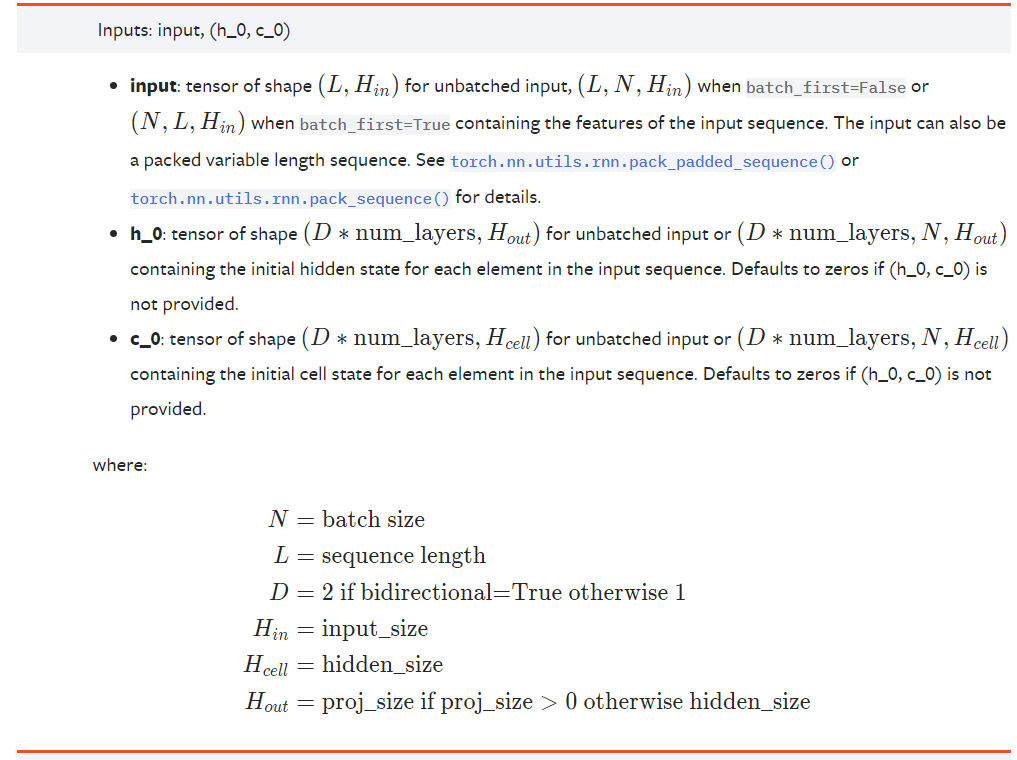

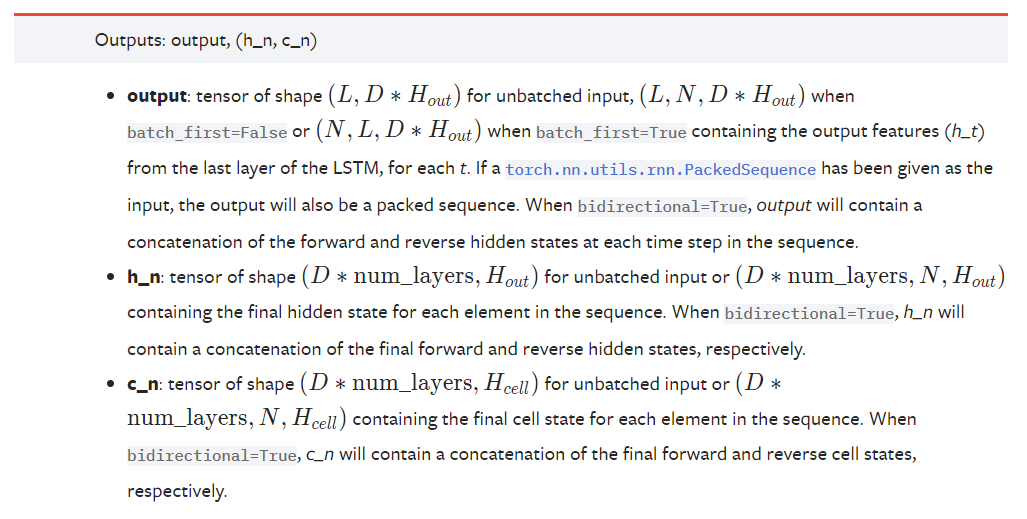

In [108]:
class Encoder(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):

        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [11, 512]
        embedded = self.dropout(self.embedding(src))
        # outputs, hidden, cell : [11, 512, 512], [2, 512, 512], [2, 512, 512]
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

Decoder is bulit using LSTM and a linear layer to creat our embedding data

In [109]:
class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):

        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.probs = nn.Softmax(dim=1)

    def forward(self, input, hidden, cell):

        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return self.probs(prediction), hidden, cell

In [110]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
    def init_hidden(self, trg_shape):

        trg_vocab_size = self.decoder.output_dim
        batch_size = trg_shape[1]
        trg_len = trg_shape[0]
        return torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        # src : [11, 512]
        # trg : [11, 512]

        trg_shape = trg.shape
        trg_len = trg_shape[0]
        outputs = self.init_hidden(trg_shape)
        hidden, cell = self.encoder(src) # [2, 512, 512] [2, 512, 512]
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [111]:
seed = 71
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

input_dim = len(vocabulary)
print('input dimension', input_dim)
output_dim = len(vocabulary)
enc_emb_dim = 256
dec_emb_dim = 256
hid_dim = 512
n_layer = 2
enc_dropout = 0.5
dec_dropout = 0.5

enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layer, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layer, dec_dropout)
model = Seq2Seq(enc, dec, device).to(device)
# When using apply, the init_weights function will be called on every module and sub-module within our model.
# For each module we loop through all of the parameters and sample them from a uniform distribution with nn.init.uniform_.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

input dimension 17778


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(17778, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(17778, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=17778, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (probs): Softmax(dim=1)
  )
)

In [112]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,578,866 trainable parameters


our loss function mustn't cosider 'unk' as mismatch

In [113]:
optimizer = optim.Adam(model.parameters())
target_padding_index = vocabulary("<unk>")
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index).to(device)

In [114]:
print(len(first_batch[1]))

11


In [115]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    ns = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:,].reshape(output.shape[0])
            trg = trg.type(torch.LongTensor).to(device)
            loss = criterion(output, trg)
            correct += (output.argmax(1) == trg).type(torch.float).sum().item()
            ns += src.shape[1]
            epoch_loss += loss.item()
    correct /= ns
    return correct , epoch_loss / len(iterator)


def train(model, iterator, optimizer, criterion, clip):
    epoch_loss = 0
    ns = 0
    aize = len(iterator)
    correct = 0
    for i, batch in enumerate(iterator):
        src, trg = batch   # [11, 512] [11, 512]
        optimizer.zero_grad()    # [11, 512, 17778]
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:,].view(-1, output_dim)
        trg = trg[1:,].reshape(output.shape[0])
        trg = trg.type(torch.LongTensor).to(device)
        loss = criterion(output, trg)
        correct += (output.argmax(1) == trg).type(torch.float).sum().item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        ns += src.shape[1]
        epoch_loss += loss.item()
    correct /= ns
    return correct, epoch_loss / len(iterator)

In [116]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Time: 0m 43s
	Train Loss: 9.636 | Train PPL: 15298.607 | Train acc: 1.128
	 Val. Loss: 9.594 |  Val. PPL: 14675.281 | Val acc: 1.289
Epoch: 02 | Time: 0m 43s
	Train Loss: 9.595 | Train PPL: 14688.717 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14674.309 | Val acc: 1.289
Epoch: 03 | Time: 0m 43s
	Train Loss: 9.595 | Train PPL: 14688.234 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14674.227 | Val acc: 1.289
Epoch: 04 | Time: 0m 42s
	Train Loss: 9.595 | Train PPL: 14688.160 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14674.141 | Val acc: 1.289
Epoch: 05 | Time: 0m 42s
	Train Loss: 9.595 | Train PPL: 14688.082 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14674.124 | Val acc: 1.289
Epoch: 06 | Time: 0m 43s
	Train Loss: 9.595 | Train PPL: 14687.748 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14674.008 | Val acc: 1.289
Epoch: 07 | Time: 0m 42s
	Train Loss: 9.595 | Train PPL: 14687.471 | Train acc: 1.284
	 Val. Loss: 9.594 |  Val. PPL: 14673.964 | 

[]

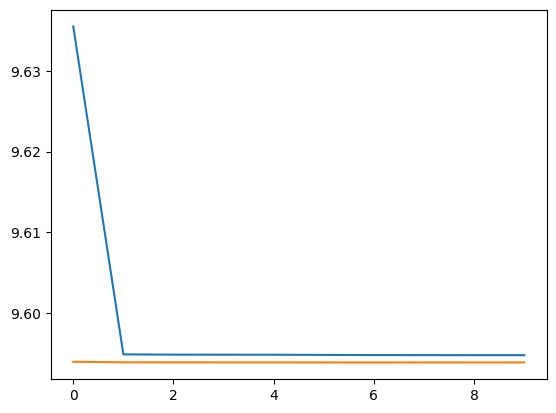

In [117]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_history = []
val_history = []
for epoch in range(N_EPOCHS):
    model.train()
    start_time = time.time()

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    val_acc, valid_loss = evaluate(model, val_loader, criterion)
    train_history += [train_loss]
    val_history += [valid_loss]
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val acc: {val_acc:.3f}')
plt.plot(range(epoch+1), train_history)
plt.plot(range(epoch+1), val_history)
plt.plot()

In [118]:
model.load_state_dict(torch.load('tut1-model.pt'))
acc, test_loss = evaluate(model, test_loader, criterion)

In [119]:
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 9.592 | Test PPL: 14654.229 |


##Part b

In [ ]:
class Encoder(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, dropout):

        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional= True)
    def forward(self, src):

        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return hidden

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, hid_dim, dropout):

        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.probs = nn.Softmax(dim=1)
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        # print("embedded shape", embedded.shape, "context",  context.shape)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.probs = nn.Softmax(dim=1)
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
    def init_hidden(self, trg_shape):
        trg_vocab_size = self.decoder.output_dim
        batch_size = trg_shape[1]
        trg_len = trg_shape[0]
        return torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        trg_len = trg.shape[0]
        trg_shape = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = self.init_hidden(trg_shape)
        context = self.encoder(src)
        context = context.unsqueeze(0)
        hidden = context
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [ ]:
seed = 68
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

input_dim = len(vocabulary)
output_dim = len(vocabulary)
enc_emb_dim = 256
dec_emb_dim = 256
hid_dim = 512
enc_dropout = 0.5
dec_dropout = 0.5

enc = Encoder(len(vocabulary), 256, 512, 0.5)
dec = Decoder(len(vocabulary), 256, 512, 0.5)
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(17778, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (rnn): GRU(256, 512, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(17778, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=17778, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (probs): Softmax(dim=1)
  )
  (probs): Softmax(dim=1)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 36,735,346 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
target_padding_index = vocabulary("<unk>")
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index).to(device)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    ns = 0
    aize = len(iterator)
    correct = 0
    for i, batch in enumerate(iterator):
        src, trg = batch
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:,].view(-1, output_dim)
        trg = trg[1:,].reshape(output.shape[0])
        trg = trg.type(torch.LongTensor).to(device)
        loss = criterion(output, trg)
        correct += (output.argmax(1) == trg).type(torch.float).sum().item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        ns += src.shape[1]
        epoch_loss += loss.item()
    correct /= ns
    return correct, epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    correct = 0
    ns = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:,].reshape(output.shape[0])
            trg = trg.type(torch.LongTensor).to(device)
            loss = criterion(output, trg)
            correct += (output.argmax(1) == trg).type(torch.float).sum().item()
            ns += src.shape[1]
            epoch_loss += loss.item()
    correct /= ns
    return correct , epoch_loss / len(iterator)

In [ ]:
def vectorize_batch(batch):
    length = 10
    X, Y = list(zip(*batch))
    X = [vocabulary(nltk.tokenize.word_tokenize(sample)) for sample in X]
    X = [sample+([2]* (length-len(sample))) if len(sample) < length else sample[:length] for sample in X]
    Y = [vocabulary(nltk.tokenize.word_tokenize(sample)) for sample in Y]
    Y = [sample+([2]* (length-len(sample))) if len(sample)<length else sample[:length] for sample in Y]
    [x.append(1) for x in X]
    [y.append(1) for y in Y]
    [x.insert(0,0) for x in X]
    [y.insert(0,0) for y in Y]
    return torch.tensor(X, dtype=torch.int32).transpose(0, 1).to(device), torch.tensor(Y, dtype=torch.int32).transpose(0, 1).to(device)
train_data, test_data, val_data = to_map_style_dataset(train_data), to_map_style_dataset(test_data), to_map_style_dataset(val_data)
train_loader = DataLoader(train_data, batch_size=512, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_data, batch_size=1, collate_fn=vectorize_batch)
val_loader  = DataLoader(val_data, batch_size=512, collate_fn=vectorize_batch)

Epoch: 01 | Time: 0m 35s
	Train Loss: 6.620 | Train PPL: 749.776 | Train acc: 1.237
	 Val. Loss: 6.052 |  Val. PPL: 424.929 | Val acc: 1.383
Epoch: 02 | Time: 0m 35s
	Train Loss: 5.909 | Train PPL: 368.455 | Train acc: 1.385
	 Val. Loss: 6.027 |  Val. PPL: 414.455 | Val acc: 1.359
Epoch: 03 | Time: 0m 35s
	Train Loss: 5.841 | Train PPL: 344.229 | Train acc: 1.396
	 Val. Loss: 6.031 |  Val. PPL: 416.029 | Val acc: 1.385
Epoch: 04 | Time: 0m 35s
	Train Loss: 5.778 | Train PPL: 323.056 | Train acc: 1.423
	 Val. Loss: 6.026 |  Val. PPL: 414.064 | Val acc: 1.384
Epoch: 05 | Time: 0m 35s
	Train Loss: 5.719 | Train PPL: 304.670 | Train acc: 1.439
	 Val. Loss: 6.031 |  Val. PPL: 416.292 | Val acc: 1.384
Epoch: 06 | Time: 0m 35s
	Train Loss: 5.683 | Train PPL: 293.913 | Train acc: 1.448
	 Val. Loss: 6.037 |  Val. PPL: 418.808 | Val acc: 1.385
Epoch: 07 | Time: 0m 36s
	Train Loss: 5.641 | Train PPL: 281.659 | Train acc: 1.467
	 Val. Loss: 6.038 |  Val. PPL: 419.111 | Val acc: 1.384
Epoch: 08 | T

[]

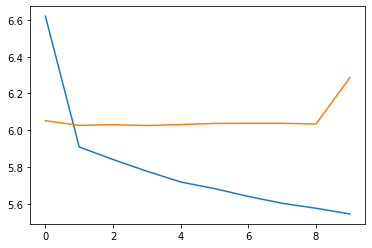

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_history = []
val_history = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_acc, train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    model.eval()
    val_acc, valid_loss = evaluate(model, val_loader, criterion)
    train_history += [train_loss]
    val_history += [valid_loss]
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val acc: {val_acc:.3f}')
plt.plot(range(epoch+1), train_history)
plt.plot(range(epoch+1), val_history)
plt.plot()

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))
acc_test, test_loss = evaluate(model, test_loader, criterion)

In [ ]:
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

از نتایج به دست آمده در دو قسمت بالا مشخص میشود استفاده از واحدهای جی.آر.یو علی رغم داشتن سادگی و نداشتن مشکلات از بین رفتن یا بزرگ شدن گرادیان به لاس کمتری منجر شد. در بالا از ایده ی دیگری که در لینک زیر وجود داشت نیز استافاده شد. و در واقع در این رویکرد خروجی انکدر به ورودی های واحد های جی.آر.یو و لایه ی تماما داده شد.

https://github.com/bentrevett/pytorch-seq2seq

https://github.com/sauravraghuvanshi/Udacity-Computer-Vision-Nanodegree-Program/tree/master/localization_exercises